In [1]:
import os
import sys
import requests

# Add the `scripts` directory to the Python path
current_dir = os.path.dirname(os.path.abspath("__file__"))
scripts_dir = os.path.abspath(os.path.join(current_dir, "../"))
sys.path.append(scripts_dir)

# Import the generate_cifar_test_files function

from generate_input_files.generate_cifar_test_files import generate_cifar_test_files

Make sure the API is running on localhost:8000 - Without Authentication!!

In [2]:
# Define paths and configurations
root_dir = os.path.abspath("../..")
tmp_folder = os.path.join(root_dir, "tmp", "increasing_epochs_test")
API_URL = "http://localhost:8000/developer/submit_job_by_model_and_data"
MINIO_URL = "http://localhost:9000"
ACCESS_KEY = "minio_user"  # Replace with your MinIO access key
SECRET_KEY = "minio_password"  # Replace with your MinIO secret key
BUCKET_NAME = "training-jobs"
DOWNLOAD_DIR = os.path.join(root_dir, "results", "performance", "increasing_epochs_test")

# Step 1: Generate CIFAR-10 test files
print("Generating CIFAR-10 test files...")
generated_files = generate_cifar_test_files(tmp_folder)
print("File generation completed.")

# Extract file paths
dataset_filename = generated_files["dataset"]
yaml_filename = generated_files["yaml"]
model_filename = generated_files["model"]

Generating CIFAR-10 test files...
CIFAR-10 images saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_epochs_test\cifar10_dataset (max 500 per class)
Dataset definition saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_epochs_test\cifar10_definition.yaml
CIFAR-10 images saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_epochs_test\cifar10_dataset (max 500 per class)
Dataset definition saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_epochs_test\cifar10_definition.yaml
Dataset zipped to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_epochs_test\cifar10_dataset.zip
Model saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_epochs_test\cifar10_model.keras
File generation completed.
Dataset zipped t

In [9]:
# --- Refactor: Repeat each experiment multiple times ---
from generate_input_files.download_results import initialize_s3_client, wait_for_job_and_download
import boto3

# Initialize the S3 client
s3_client = initialize_s3_client(MINIO_URL, ACCESS_KEY, SECRET_KEY)

# Define the epoch counts to test
epoch_counts = [1, 2, 5, 10, 50]

repeat_count = 10  # Number of times to repeat each configuration
all_epoch_results = []  # Store results for all runs

for epochs in epoch_counts:
    for repeat_idx in range(repeat_count):
        print(f"\nSubmitting job with {epochs} epochs (repeat {repeat_idx+1}/{repeat_count})...")

        # Prepare the files and data for the request
        files = {
            "model": open(model_filename, "rb"),
            "dataset": open(dataset_filename, "rb"),
            "dataset_definition": open(yaml_filename, "rb"),
        }
        data = {
            "framework": "TensorFlow 2.16.1",
            "model_name": f"performance_analysis_model_{epochs}_epochs_repeat_{repeat_idx+1}",
            "epochs": epochs,
        }

        # Submit the job
        response = requests.post(API_URL, files=files, data=data)
        print(f"Submitted: {response.status_code} {response.text}")

        # Extract the unique_dir and job_id from the API response
        response_data = response.json()
        unique_dir = response_data.get("unique_dir")
        job_id = response_data.get("job_id")
        if not unique_dir:
            raise ValueError("Error: 'unique_dir' not found in the API response.")

        # Store the mapping for this run
        all_epoch_results.append({
            "epochs": epochs,
            "repeat": repeat_idx + 1,
            "unique_dir": unique_dir,
            "job_id": job_id
        })

        # Wait for the job to finish and download the results
        print(f"Waiting for job with {epochs} epochs (repeat {repeat_idx+1}) to complete...")
        wait_for_job_and_download(s3_client, BUCKET_NAME, unique_dir, DOWNLOAD_DIR)
        print(f"Artifacts for {epochs} epochs (repeat {repeat_idx+1}) downloaded to: {DOWNLOAD_DIR}")


Submitting job with 1 epochs (repeat 1/10)...
Submitted: 200 {"job_id":"35203001-1807-4387-8c07-5dd6f334a03a","status":"Training started","unique_dir":"a88af840-f6fc-465f-b3d6-99fd56c50a4c"}
Waiting for job with 1 epochs (repeat 1) to complete...
Checking if job is finished by looking for 'output' folder in 'a88af840-f6fc-465f-b3d6-99fd56c50a4c'...
Job is not yet finished. Retrying in 10 seconds...
Checking if job is finished by looking for 'output' folder in 'a88af840-f6fc-465f-b3d6-99fd56c50a4c'...
Downloaded: a88af840-f6fc-465f-b3d6-99fd56c50a4c/dataset/cifar10_dataset.zip -> c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\performance\increasing_epochs_test\a88af840-f6fc-465f-b3d6-99fd56c50a4c/dataset/cifar10_dataset.zip
Downloaded: a88af840-f6fc-465f-b3d6-99fd56c50a4c/definition/cifar10_definition.yaml -> c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\performance\increasing_epochs_test\a88af840-f6fc-465f-b3

KeyboardInterrupt: 

In [3]:
from generate_input_files.download_results import initialize_s3_client, wait_for_job_and_download
import boto3

# Initialize the S3 client
s3_client = initialize_s3_client(MINIO_URL, ACCESS_KEY, SECRET_KEY)

# Define the epoch counts to test
epoch_counts = [1, 2, 5, 10, 50, 100]
epoch_mapping = {}  # Dictionary to map epochs to unique_dir and job_id

# Step 2: Submit jobs with increasing epochs
for epochs in epoch_counts:
    print(f"\nSubmitting job with {epochs} epochs...")

    # Prepare the files and data for the request
    files = {
        "model": open(model_filename, "rb"),
        "dataset": open(dataset_filename, "rb"),
        "dataset_definition": open(yaml_filename, "rb"),
    }
    data = {
        "framework": "TensorFlow 2.16.1",
        "model_name": f"performance_analysis_model_{epochs}_epochs",
        "epochs": epochs,
    }

    # Submit the job
    response = requests.post(API_URL, files=files, data=data)
    print(f"Submitted: {response.status_code} {response.text}")

    # Extract the unique_dir and job_id from the API response
    response_data = response.json()
    unique_dir = response_data.get("unique_dir")
    job_id = response_data.get("job_id")  # Assuming the API returns a job_id
    if not unique_dir:
        raise ValueError("Error: 'unique_dir' not found in the API response.")

    # Store the mapping
    epoch_mapping[epochs] = {"unique_dir": unique_dir, "job_id": job_id}

    # Wait for the job to finish and download the results
    print(f"Waiting for job with {epochs} epochs to complete...")
    wait_for_job_and_download(s3_client, BUCKET_NAME, unique_dir, DOWNLOAD_DIR)
    print(f"Artifacts for {epochs} epochs downloaded to: {DOWNLOAD_DIR}")


Submitting job with 1 epochs...
Submitted: 200 {"job_id":"47331a01-064a-42fa-9f3d-647d3e994f31","status":"Training started","unique_dir":"ccc35e44-48a1-443d-bec9-560acc630f97"}
Waiting for job with 1 epochs to complete...
Checking if job is finished by looking for 'output' folder in 'ccc35e44-48a1-443d-bec9-560acc630f97'...
Job is not yet finished. Retrying in 10 seconds...
Checking if job is finished by looking for 'output' folder in 'ccc35e44-48a1-443d-bec9-560acc630f97'...
Downloaded: ccc35e44-48a1-443d-bec9-560acc630f97/dataset/cifar10_dataset.zip -> c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\performance\increasing_epochs_test\ccc35e44-48a1-443d-bec9-560acc630f97/dataset/cifar10_dataset.zip
Downloaded: ccc35e44-48a1-443d-bec9-560acc630f97/definition/cifar10_definition.yaml -> c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\performance\increasing_epochs_test\ccc35e44-48a1-443d-bec9-560acc630f97/definitio

In [27]:
import os
from datetime import datetime
import pandas as pd
import numpy as np

# Define the path to the job result folders
results_dir = DOWNLOAD_DIR  # Use the DOWNLOAD_DIR defined earlier
log_filename = "logs.log"  # Name of the log file in each job folder

# Function to parse a timestamp string into a datetime object
def parse_log_timestamp(timestamp_str):
    return datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S,%f")

# Function to extract timings from a log file
def extract_timings_from_log(log_file_path):
    timings = {}
    with open(log_file_path, "r") as log_file:
        for line in log_file:
            if "Training started at UTC" in line:
                timings["training_start"] = parse_log_timestamp(line.split(" - ")[0])
            elif "AIBoM generation started at UTC" in line:
                timings["aibom_start"] = parse_log_timestamp(line.split(" - ")[0])
            elif "Task completed successfully" in line:
                timings["task_complete"] = parse_log_timestamp(line.split(" - ")[0])
    return timings

# Process each job folder (now using all_epoch_results)
job_timings = []  # Use a list to store job timings

for run in all_epoch_results:
    epochs = run["epochs"]
    repeat = run["repeat"]
    unique_dir = run["unique_dir"]
    job_folder = os.path.join(results_dir, unique_dir)
    log_file_path = os.path.join(job_folder, "output", log_filename)
    
    if os.path.exists(log_file_path):
        print(f"Processing log file for epoch {epochs} (repeat {repeat}): {log_file_path}")
        timings = extract_timings_from_log(log_file_path)
        if "training_start" in timings and "aibom_start" in timings and "task_complete" in timings:
            training_duration = (timings["aibom_start"] - timings["training_start"]).total_seconds()
            aibom_duration = (timings["task_complete"] - timings["aibom_start"]).total_seconds()
            total_duration = (timings["task_complete"] - timings["training_start"]).total_seconds()
            job_timings.append({
                "epochs": epochs,
                "repeat": repeat,
                "training_start": timings["training_start"],
                "training_duration": training_duration,
                "aibom_duration": aibom_duration,
                "total_duration": total_duration,
            })
        else:
            print(f"Warning: Missing timestamps in {log_file_path}")
    else:
        print(f"Warning: Log file not found for epoch {epochs} (repeat {repeat})")

# Convert to DataFrame for aggregation
df = pd.DataFrame(job_timings)

# Aggregate: mean and std for each epoch value
agg_df = df.groupby("epochs").agg({
    "training_duration": ["mean", "std"],
    "aibom_duration": ["mean", "std"],
    "total_duration": ["mean", "std"]
}).reset_index()

# Print aggregated results
print("\nAggregated Timings (Mean ± Std by Epochs):")
print(agg_df)

# Save to CSV
agg_df.to_csv(os.path.join(DOWNLOAD_DIR, "performance_analysis_epoch_agg_results.csv"), index=False)

# Save non-aggregated raw results to CSV
df.to_csv(os.path.join(DOWNLOAD_DIR, "performance_analysis_epoch_raw_results.csv"), index=False)

Processing log file for epoch 1 (repeat 1): c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\performance\increasing_epochs_test\a88af840-f6fc-465f-b3d6-99fd56c50a4c\output\logs.log
Processing log file for epoch 1 (repeat 2): c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\performance\increasing_epochs_test\debedbb0-9bc7-4e3b-9548-55f603d37c65\output\logs.log
Processing log file for epoch 1 (repeat 3): c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\performance\increasing_epochs_test\20793410-3040-4855-a3b8-4713add4d9ec\output\logs.log
Processing log file for epoch 1 (repeat 4): c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\performance\increasing_epochs_test\ffecd67b-66e7-432d-ab75-763f7512f844\output\logs.log
Processing log file for epoch 1 (repeat 5): c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\per

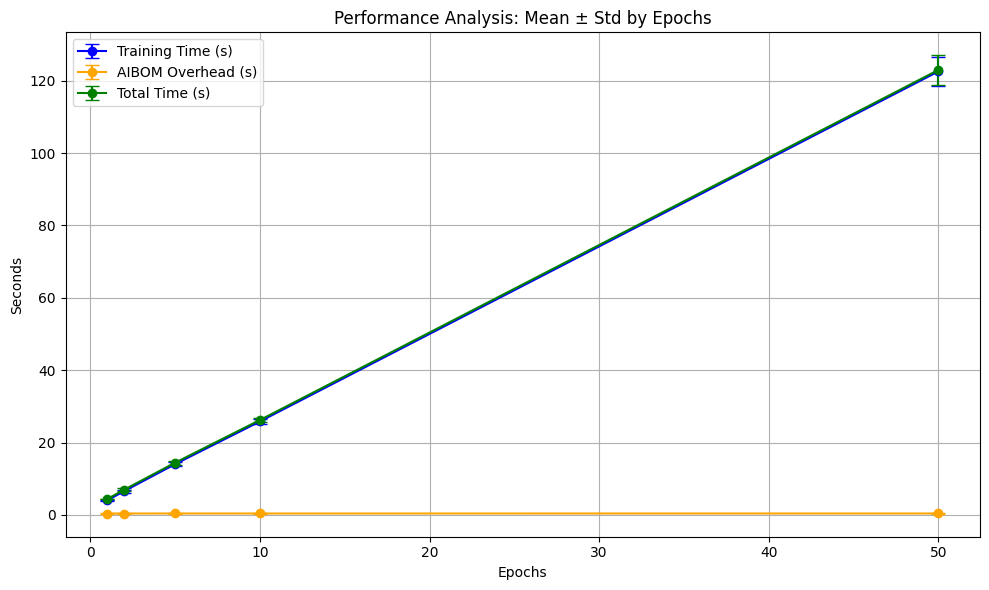

   Epochs  Training Mean (s)  Training Std (s)  AIBOM Mean (s)  AIBOM Std (s)  \
0       1           3.993600          0.092746        0.372500       0.016263   
1       2           6.574400          0.405511        0.378900       0.026459   
2       5          14.019200          0.527261        0.390600       0.075008   
3      10          25.821800          0.655375        0.383100       0.073035   
4      50         122.574556          4.046224        0.388222       0.087473   

   Total Mean (s)  Total Std (s)  
0        4.366100       0.094427  
1        6.953300       0.399724  
2       14.409800       0.519283  
3       26.204900       0.632709  
4      122.962778       4.064952  


In [28]:
# --- Analysis of Aggregated Results ---
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

agg_csv_path = os.path.join(DOWNLOAD_DIR, "performance_analysis_epoch_agg_results.csv")
agg_df = pd.read_csv(agg_csv_path, header=[0,1])

# Extract columns using multi-row header
epochs = agg_df.iloc[:,0]
training_mean = agg_df[('training_duration', 'mean')]
training_std = agg_df[('training_duration', 'std')]
aibom_mean = agg_df[('aibom_duration', 'mean')]
aibom_std = agg_df[('aibom_duration', 'std')]
total_mean = agg_df[('total_duration', 'mean')]
total_std = agg_df[('total_duration', 'std')]

# Plot mean and std as error bars
plt.figure(figsize=(10, 6))
plt.errorbar(epochs, training_mean, yerr=training_std, fmt='o-', label='Training Time (s)', color='blue', capsize=5)
plt.errorbar(epochs, aibom_mean, yerr=aibom_std, fmt='o-', label='AIBOM Overhead (s)', color='orange', capsize=5)
plt.errorbar(epochs, total_mean, yerr=total_std, fmt='o-', label='Total Time (s)', color='green', capsize=5)
plt.xlabel('Epochs')
plt.ylabel('Seconds')
plt.title('Performance Analysis: Mean ± Std by Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(DOWNLOAD_DIR, "performance_analysis_epoch_agg_plot.png"))
plt.show()

# Print summary table
summary_df = pd.DataFrame({
    'Epochs': epochs,
    'Training Mean (s)': training_mean,
    'Training Std (s)': training_std,
    'AIBOM Mean (s)': aibom_mean,
    'AIBOM Std (s)': aibom_std,
    'Total Mean (s)': total_mean,
    'Total Std (s)': total_std,
})
print(summary_df)

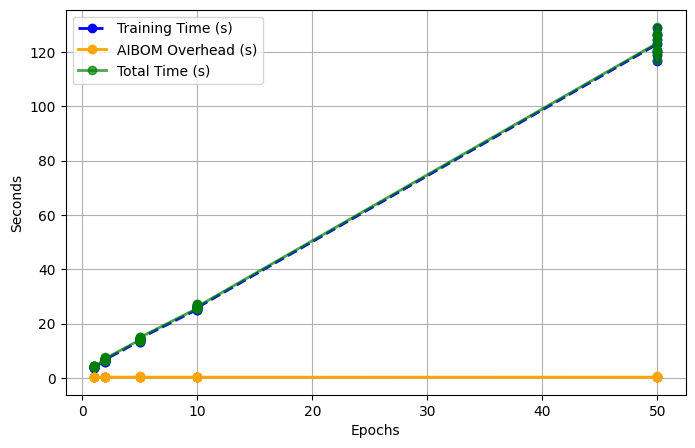

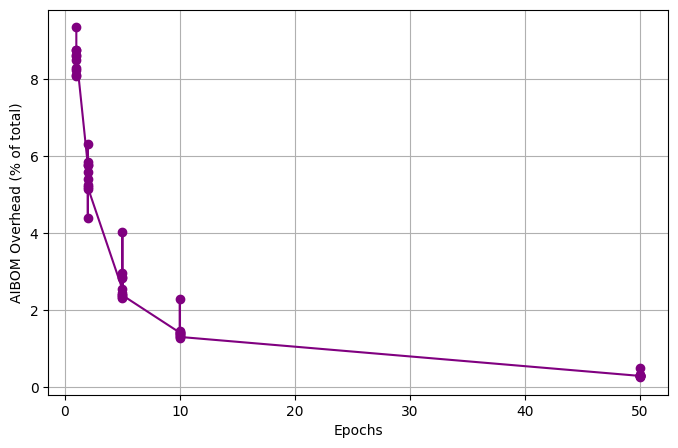

    Epochs  Training Time (s)  AIBOM Time (s)  Total Time (s)  \
0        1              3.986           0.411           4.397   
1        1              3.874           0.372           4.246   
2        1              4.122           0.364           4.486   
3        1              4.126           0.373           4.499   
4        1              3.912           0.368           4.280   
5        1              4.021           0.354           4.375   
6        1              4.042           0.363           4.405   
7        1              3.855           0.358           4.213   
8        1              3.996           0.384           4.380   
9        1              4.002           0.378           4.380   
10       2              6.249           0.382           6.631   
11       2              6.678           0.382           7.060   
12       2              6.792           0.369           7.161   
13       2              6.104           0.362           6.466   
14       2              6

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract data for analysis
epochs_list = [job["epochs"] for job in job_timings]
training_times = [job["training_duration"] for job in job_timings]
aibom_times = [job["aibom_duration"] for job in job_timings]
total_times = [job["total_duration"] for job in job_timings]

# Plot Training Time vs Epochs
plt.figure(figsize=(8, 5))
plt.plot(epochs_list, training_times, marker='o', label='Training Time (s)', linestyle='--', color='blue', linewidth=2)
plt.plot(epochs_list, aibom_times, marker='o', label='AIBOM Overhead (s)', linestyle='-', color='orange', linewidth=2)
plt.plot(epochs_list, total_times, marker='o', label='Total Time (s)', linestyle='-', color='green', linewidth=2, alpha=0.7)
plt.xlabel('Epochs')
plt.ylabel('Seconds')
plt.legend()
plt.grid(True)

plt.savefig(os.path.join(DOWNLOAD_DIR, "training_aibom_total_time_plot.png"))


plt.show()


# Plot AIBoM Overhead as Percentage of Total Time
overhead_pct = (np.array(aibom_times) / np.array(total_times)) * 100

plt.figure(figsize=(8, 5))
plt.plot(epochs_list, overhead_pct, marker='o', color='purple')
plt.xlabel('Epochs')
plt.ylabel('AIBOM Overhead (% of total)')
plt.grid(True)

plt.savefig(os.path.join(DOWNLOAD_DIR, "aibom_overhead_percentage_plot.png"))

plt.show()


# Print Table
df = pd.DataFrame({
    "Epochs": epochs_list,
    "Training Time (s)": training_times,
    "AIBOM Time (s)": aibom_times,
    "Total Time (s)": total_times,
    "AIBOM Overhead (%)": overhead_pct
})
print(df)

df.to_csv(os.path.join(DOWNLOAD_DIR, "performance_analysis_epoch_results.csv"), index=False)
